# Assignment: Follow-ups to Parameter Estimation notebooks 

**Goal:** work through the `parameter_estimation_fitting_straight_line_I.ipynb` and `amplitude_in_presence_of_background.ipynb` notebooks, doing some of the suggested tasks and answering selected questions, as detailed below.  

## Learning goals:
* Improve your understanding of the Python code in our sample notebooks.
* Be able to articulate basic scaling of fluctuations, the signature of correlations, and the role of priors.
* Gain experience with a basic Bayesian experimental design problem.
* Explore an example of the central limit theorem both analytically and numerically.

## A. Parameter estimation example: fitting a straight line I

1. Step through the notebook and make sure you understand the notation and calculations.  Try writing the requested pieces of Python code; if you have difficulty, study the supplied code instead and identify what parts you don't understand.  (You don't need to hand in anything for this part but please list here any questions you have.)
<br><br><br><br>

1. Do exercise 3: Change the random number seed to get different results and comment on how the maximum likelihood results fluctuate. How is the typical size of fluctuations related to the number of data points $N$ and the data error standard deviation $dy$? E.g., are they proportional to $N$ or $dy^2$ or what?  (Try changing $N$ and $dy$ to test your answer!)
<br><br><br><br>

1. In both sets of joint posterior graphs, are the slope and intercept correlated?  How do you know? Explain how they get correlated.
<br><br><br><br>

1. For the first set of data, answer the question: "What do you conclude about how the form of the prior affects the final posterior in this case?"
<br><br><br><br>

1. For the second set of data, answer the question: "Why in this case does the form of the prior have a clear effect?"  You should consider both the size of the error bars and the number of data points (and try changing them to verify the impact).
<br><br><br><br>


### Solution for 2

<br> The fluctuation of the maximum likelihood estimation decrease as 1/N, and increase as dy^2, as shown below from the Mean squared error calculations

In [228]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy.optimize import curve_fit

def make_data(b, m, N, dy, rseed):

    rand = np.random.RandomState(rseed) 
    x = 100 * rand.rand(N)  # choose the x values randomly in [0,100]
    y = b + m * x  # This is the y value without noise
    y += dy * rand.randn(N)    # Add in Gaussian noise
    return x, y, dy * np.ones_like(x)  # return coordinates and error bars

def log_likelihood(theta,x,y,dy):
    b,m = theta
    y_th = b+m*x
    return -0.5 * np.sum(np.log(2 * np.pi * dy**2) + (y - y_th)**2 / dy**2)

def min_likelihood_optimize(theta,x,y,dy):
    return -1*log_likelihood(theta,x,y,dy)

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

In [229]:
def plot_variable_seed(b_true, m_true, N, dy,Seed_no):

    Rseed = np.random.randint(0,1000000,size=Seed_no)
    b_opt = []
    m_opt = []

    for rseed in Rseed:

        x,y,dy = make_data(b_true, m_true, N, dy, rseed)
        result = optimize.minimize(min_likelihood_optimize, x0=[0, 0], args=(x, y, dy))
        b_opt.append(result.x[0])
        m_opt.append(result.x[1])
    
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title("Fluctuation of likelihood estimated intercept")
    ax1.plot(b_opt,marker = "o", color='blue')
    ax1.axhline(y=b_true)
    ax1.set_xlabel("Seed number")
    ax1.set_ylabel(r"$b_{estimated}$")

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Fluctuation of likelihood estimated slope")
    ax2.plot(m_opt, marker = "o",color='red')
    ax2.axhline(y=m_true)
    ax2.set_xlabel("Seed number")
    ax2.set_ylabel(r"$m_{estimated}$")
    

In [230]:
def fluctuation_estimate(b_true, m_true, N, dy, Seed_no):

    Rseed = np.random.randint(0,1000000,size=Seed_no)
    b_opt = []
    m_opt = []
    
    b_var = 0
    m_var = 0
    
    for rseed in Rseed:

        x,y,dy = make_data(b_true, m_true, N, dy, rseed)
        result = optimize.minimize(min_likelihood_optimize, x0=[0, 0], args=(x, y, dy))
        b_opt.append(result.x[0])
        m_opt.append(result.x[1])
        
        b_var = b_var+(result.x[0]-b_true)**2
        m_var = m_var+(result.x[1]-m_true)**2
    
    return b_var/Seed_no,m_var/Seed_no

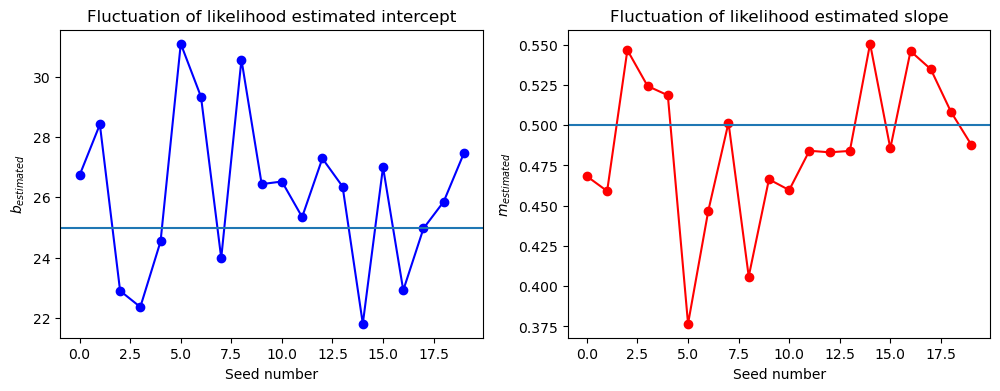

In [231]:
#Fixing N, dy, looking at fluctuation of the estimated intercept and slope as we change random seed

b_true = 25
m_true = 0.5
theta_true = [b_true, m_true]
N=20
dy=5

Seed_no = 20 #no of initial seeds to consider
plot_variable_seed(b_true, m_true, N, dy,Seed_no)


In [236]:
# Calculate how does the Mean square error of the estimate change with N, dy (here, mean is calculated over a
# set of random initial seeds. We consider a sufficiently large number of trials

# Case 1) Fix N, change dy

N = 256
Dy = np.logspace(-1,1,num=11)
Seed_no = 2000

b_fluct = []
m_fluct = []
for dy in Dy:
    Intercept_mse,Slope_mse = fluctuation_estimate(b_true, m_true, N, dy, Seed_no)
    b_fluct.append(Intercept_mse)
    m_fluct.append(Slope_mse)


[ 1.97332387e+00  1.71065936e-02 -9.68933860e-04]
[-5.72116844e-05 -1.21828648e+00  1.21836017e+00]


Text(0, 0.5, '$MSE(m_{estimated})$')

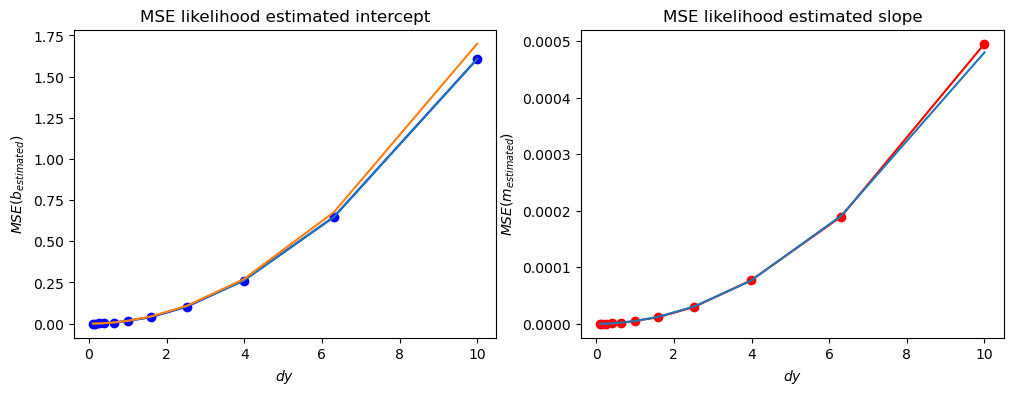

In [256]:
popt_b, pcov_b = curve_fit(func_powerlaw, Dy, b_fluct)
popt_m, pcov_m = curve_fit(func_powerlaw, Dy, m_fluct)

print(popt_b)
print(popt_m)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("MSE likelihood estimated intercept")
ax1.plot(Dy,b_fluct,marker = "o", color='blue')
ax1.plot(Dy,func_powerlaw(np.array(Dy), *popt_b))
ax1.plot(Dy,0.017*np.power(Dy,2))
#ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xlabel(r"$dy$")
ax1.set_ylabel(r"$MSE(b_{estimated})$")

ax2 = fig.add_subplot(1,2,2)
ax2.set_title("MSE likelihood estimated slope")
ax2.plot(Dy,m_fluct, marker = "o",color='red')
#ax2.plot(Dy,func_powerlaw(np.array(Dy), *popt_m))
ax2.plot(Dy,0.0000048*np.power(Dy,2))
#ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel(r"$dy$")
ax2.set_ylabel(r"$MSE(m_{estimated})$")

In [257]:
# Case 2) Fix dy, change N

N = np.array([8,16,32,64,128,256,512,1024])
#Dy = [0.2,0.5,1,2,5,10]
dy = 5
Seed_no = 2000

b_fluct = []
m_fluct = []
for n in N:
    Intercept_mse,Slope_mse = fluctuation_estimate(b_true, m_true, n, dy, Seed_no)
    b_fluct.append(Intercept_mse)
    m_fluct.append(Slope_mse)


[ 1.97332387e+00  1.71065936e-02 -9.68933860e-04]
[-5.72116844e-05 -1.21828648e+00  1.21836017e+00]


Text(0, 0.5, '$MSE(m_{estimated})$')

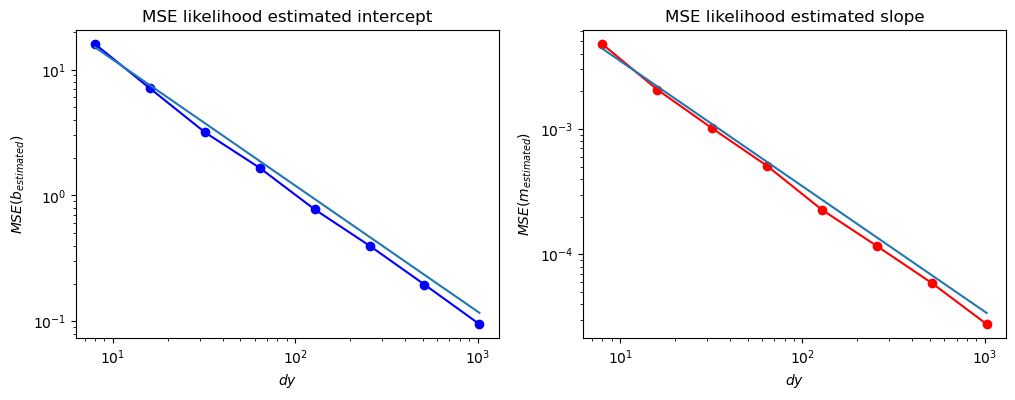

In [276]:
#popt_b, pcov_b = curve_fit(func_powerlaw, N, b_fluct)
#popt_m, pcov_m = curve_fit(func_powerlaw, N, m_fluct)

print(popt_b)
print(popt_m)
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("MSE likelihood estimated intercept")
ax1.plot(N,b_fluct,marker = "o", color='blue')
ax1.plot(N,120*np.power(N,-1,dtype=float))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r"$dy$")
ax1.set_ylabel(r"$MSE(b_{estimated})$")

ax2 = fig.add_subplot(1,2,2)
ax2.set_title("MSE likelihood estimated slope")
ax2.plot(N,m_fluct, marker = "o",color='red')
ax2.plot(N,0.035*np.power(N,-1,dtype=float))
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r"$dy$")
ax2.set_ylabel(r"$MSE(m_{estimated})$")

### Solution for 3

<br> The slopes and intercepts are correlated, as seen from the joint posterior distribution curves. Increasing the most likely value of slope results in decreasing the most likely value of the intercept, and vice versa.

<br> This can be understood by looking at the likelihood function. Since the log likelihood function(that yields the posterior distribution) has an explicit factor of $$(y_i-(mx_i+b)$$

<br> Extremizing the likelihood function (or the joint posterior distribution), for a given set of y_i and x_i would imply that if m is increased, b has to be decreased at the maxima/minima.

### Solution for 4

<br> For the first set of data (large value of N), the form of the prior does not affect the posterior much. This can be seen by noting that (ignoring the overall constant)

$$ \log(posterior) = \log(likelihood)+\log(prior)$$,
$$
\log(likelihood) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$

For large N, and small errors, the log likelihood term dominates, and hence the form of the prior doesn't contribute much to the overall posterior distribution

### Solution for 5


$$\log(likelihood) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\varepsilon_i^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\varepsilon_i^2}\right)
$$

<br> If the errors are very large, or the number of points (y_i,x_i) are small, then only the first term in the log likelihood function dominates. However, this would then imply that the distribution of the points (y_i,x_i) is irrelelvant, and the log(likelihood) function saturates towards a "constant" or featureless distribution. The posterior distributions details is thus heavily influenced by the prior, and hence the prior distribution makes an effect in this case

In [286]:
# Code from class notebook

def log_flat_prior(theta):
    """Flat prior on value of slope m"""
    if np.all(np.abs(theta) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_symmetric_prior(theta):
    """Prior p(m) proportional to (1 + m^2)^{-3/2}"""
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1]**2)
    else:
        return -np.inf  # log(0)
    
def contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior"""
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997])**2)
    return np.sort(sorted_[cutoffs])

def plot_results(x, y, dy,
                 slope_limits=(0.3, 0.7),
                 intercept_limits=(15, 35)):
    # 1. Evaluate the log probability on the grid (once for each prior)
    slope_range = np.linspace(*slope_limits)
    intercept_range = np.linspace(*intercept_limits)

    log_P1 = [[log_likelihood([b, m], x, y, dy) + log_flat_prior([b, m])
               for m in slope_range] for b in intercept_range]
    log_P2 = [[log_likelihood([b, m], x, y, dy) + log_symmetric_prior([b, m]) 
               for m in slope_range] for b in intercept_range]

    # For convenience, we normalize the pdf such that the maximum is 1
    P1 = np.exp(log_P1 - np.max(log_P1))
    P2 = np.exp(log_P2 - np.max(log_P2))

    # 2. Create two subplots and plot contours showing the results
    fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                           sharex=True, sharey=True)
    
    ax[0].contourf(slope_range, intercept_range, P1, 100, cmap='Blues')
    ax[0].contour(slope_range, intercept_range, P1, contour_levels(P1), 
                  colors='black')
    ax[0].set_title('Flat Prior')

    ax[1].contourf(slope_range, intercept_range, P2, 100, cmap='Blues')
    ax[1].contour(slope_range, intercept_range, P2, contour_levels(P2), 
                  colors='black')
    ax[1].set_title('Symmetric Prior')

    # 3. Add grids and set axis labels
    for axi in ax:
        axi.grid('on', linestyle=':', color='gray', alpha=0.5)
        axi.set_axisbelow(False)
        axi.set_xlabel('slope')
        axi.set_ylabel('intercept')
    
    overall_title = f'N = {N},  ' \
                    + f'dy = {dy[0]}' \
                    + '\n'
    fig.suptitle(overall_title, y=1.01)
    
    fig.tight_layout()

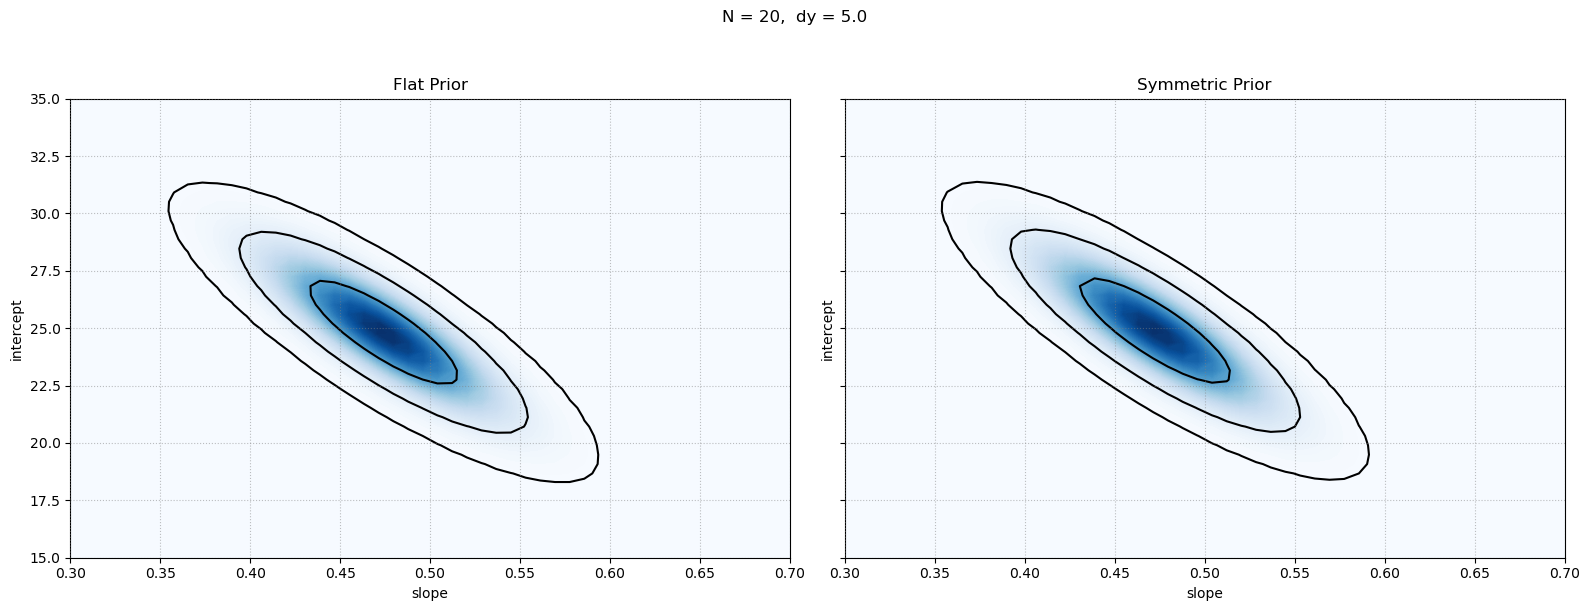

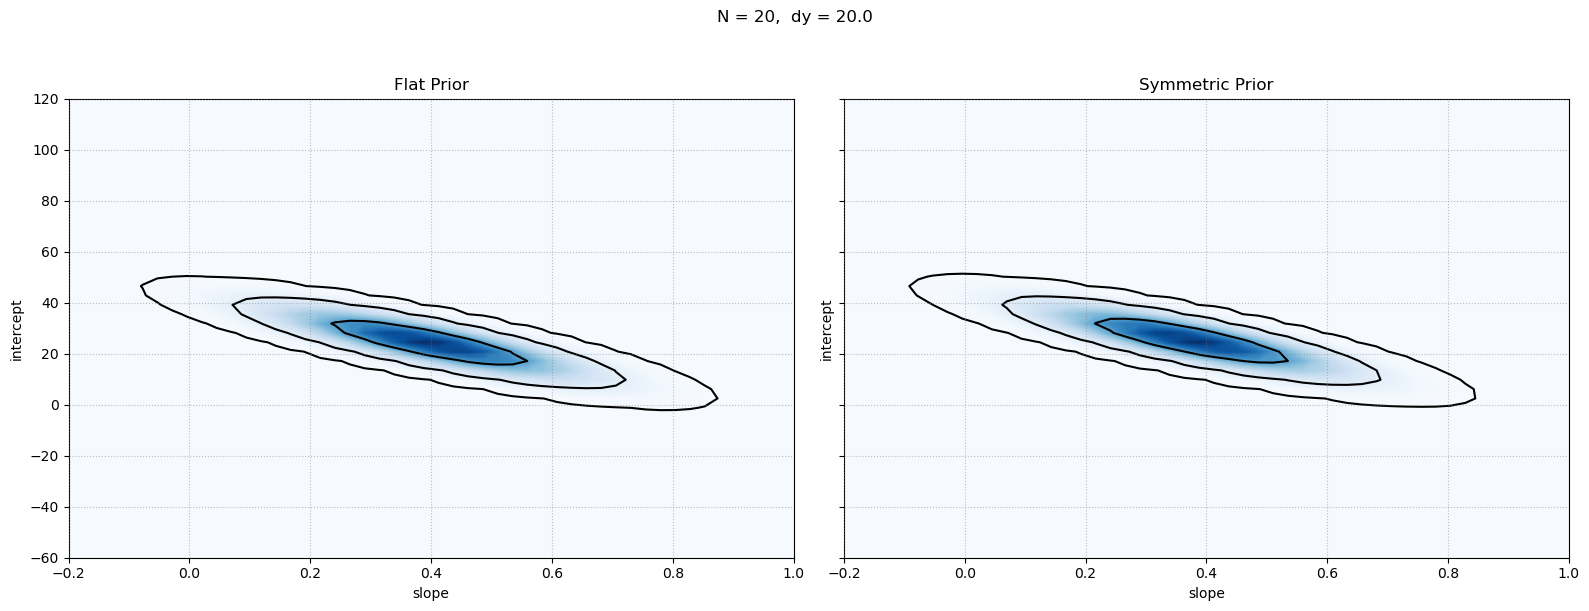

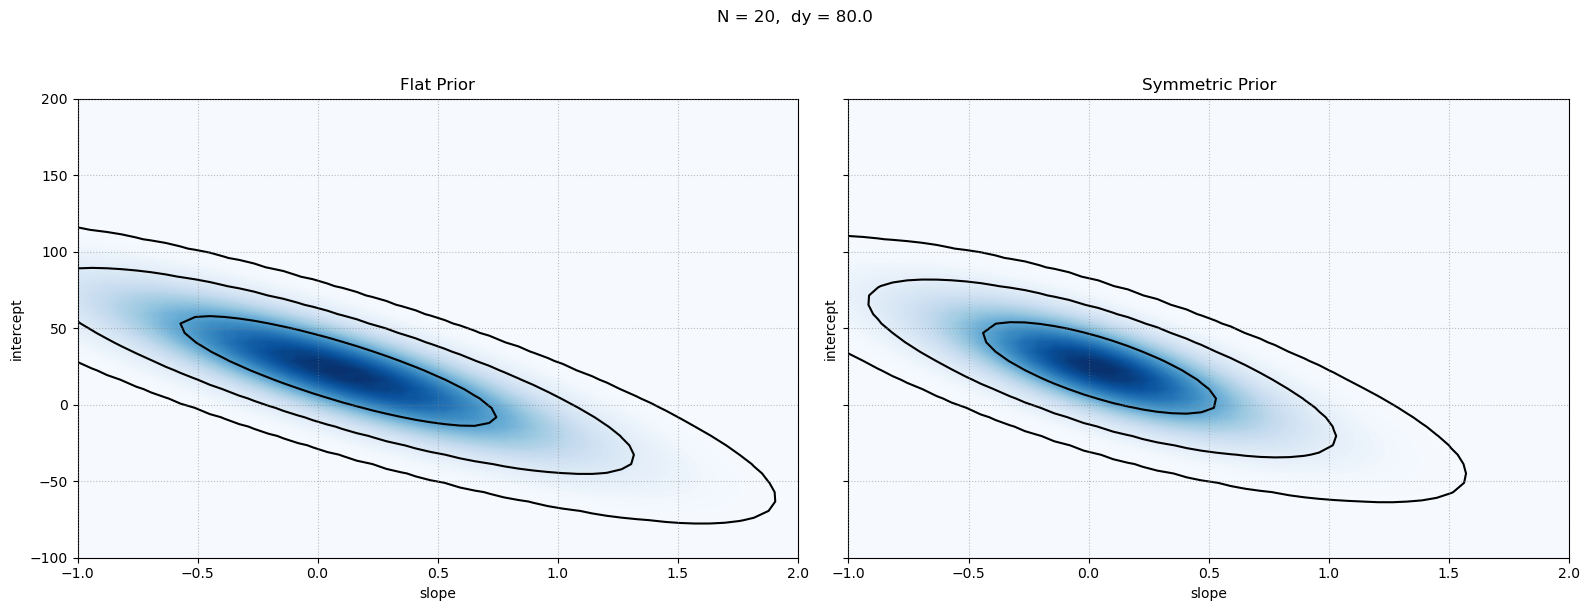

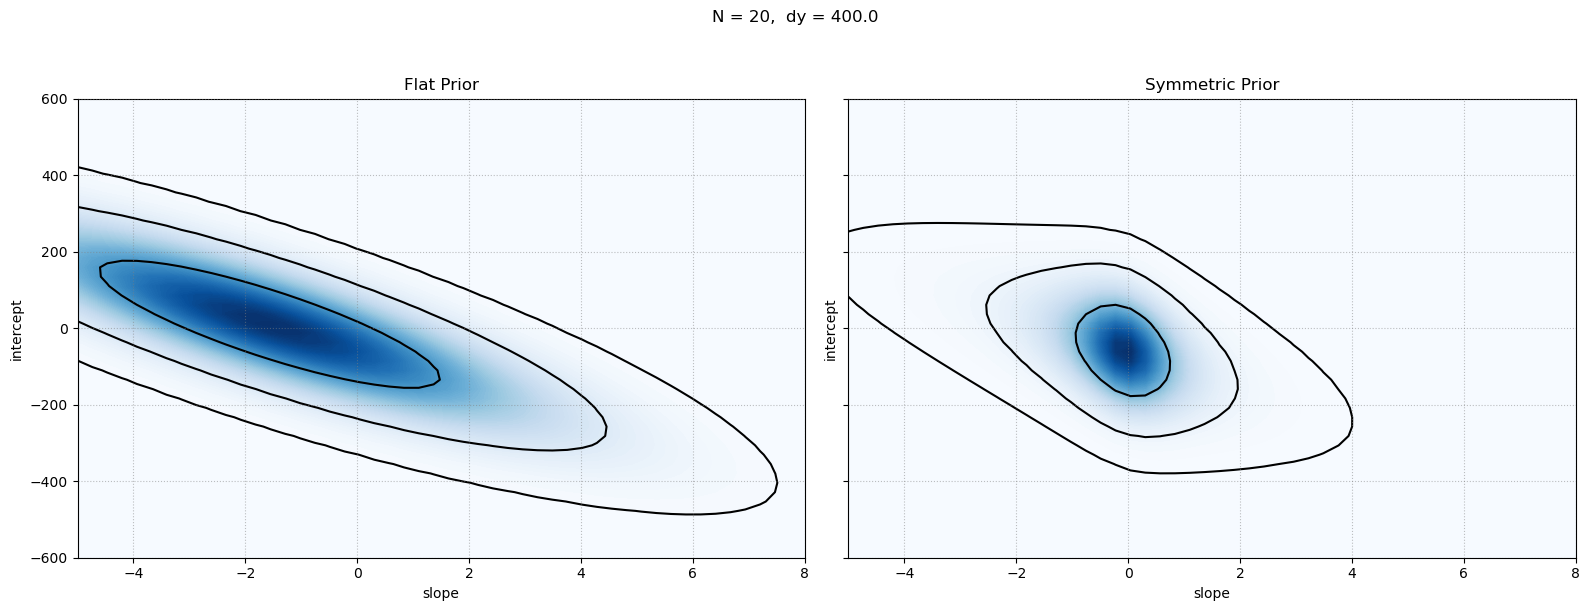

In [313]:
intercept = 25.   
slope = 0.5      
theta_true = [intercept, slope]

N=20 #Large N, small dy
dy=5
x, y, dy = make_data(*theta_true, N,dy,rseed=42)
plot_results(x, y, dy,intercept_limits=(15, 35))

N=20 #Large N, moderate dy
dy=20
x, y, dy = make_data(*theta_true, N,dy,rseed=42)
plot_results(x, y, dy,intercept_limits=(-60, 120),slope_limits=(-0.2,1))

N=20 #Large N, large dy
dy=80
x, y, dy = make_data(*theta_true, N,dy,rseed=42)
plot_results(x, y, dy,intercept_limits=(-100, 200),slope_limits=(-1,2))

N=20 #Large N, large dy
dy=400
x, y, dy = make_data(*theta_true, N,dy,rseed=42)
plot_results(x, y, dy,intercept_limits=(-600, 600),slope_limits=(-5, 8))

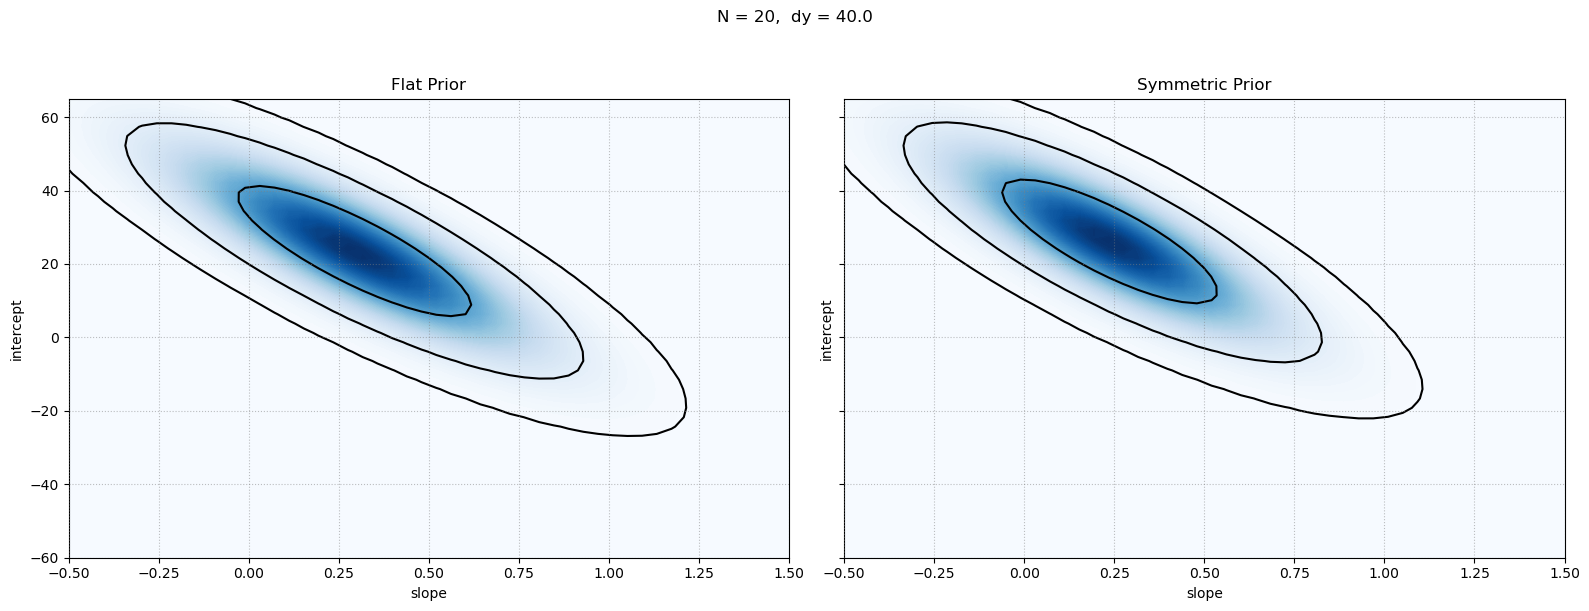

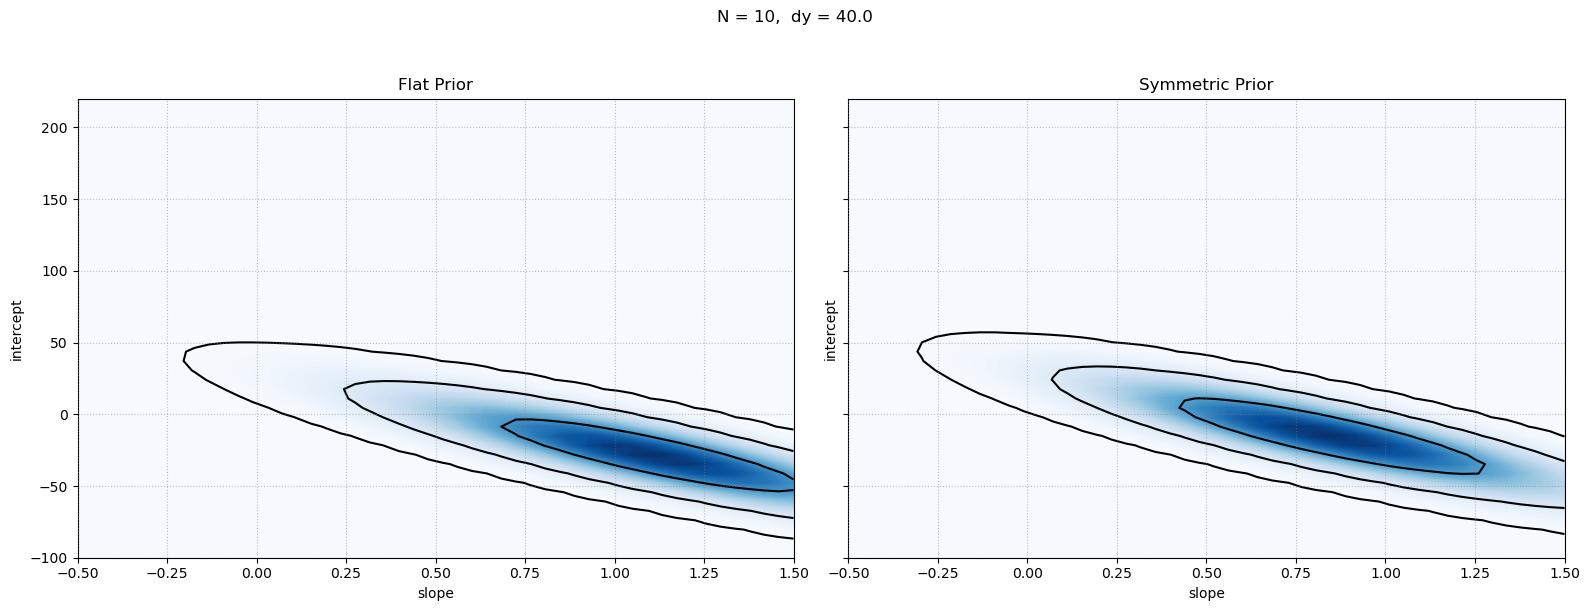

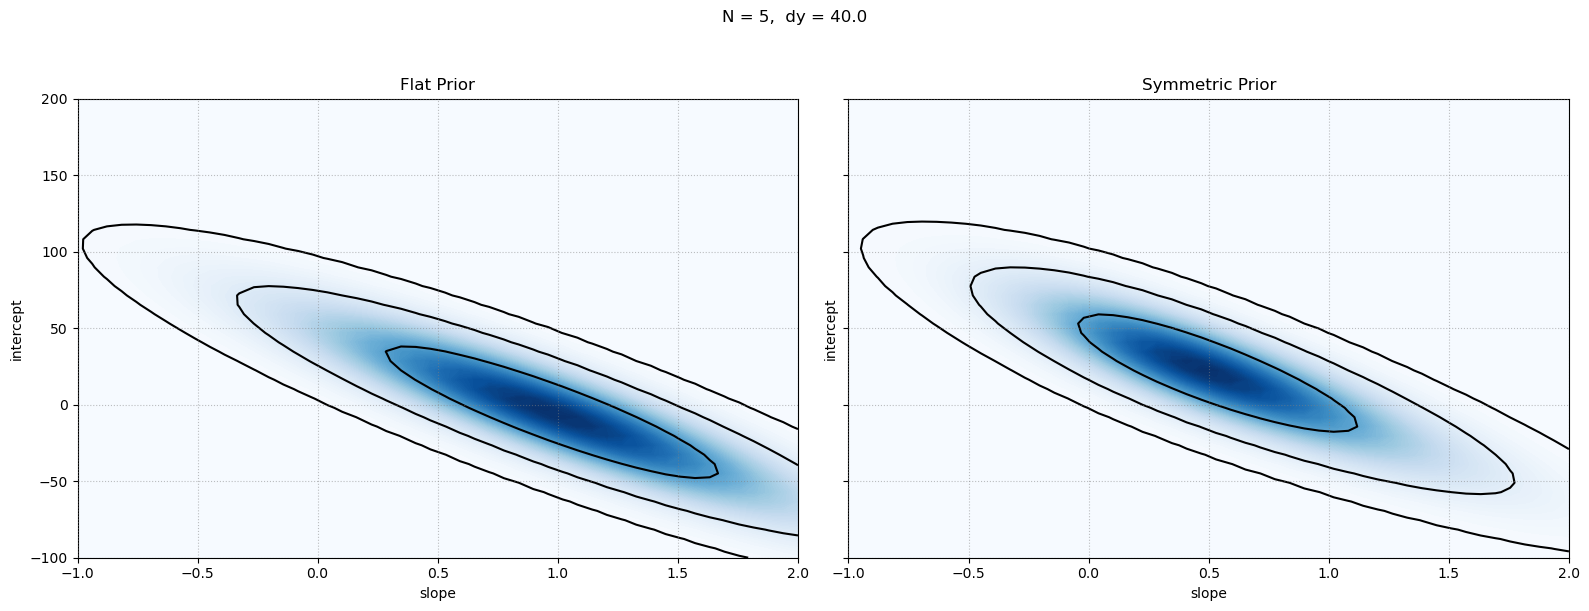

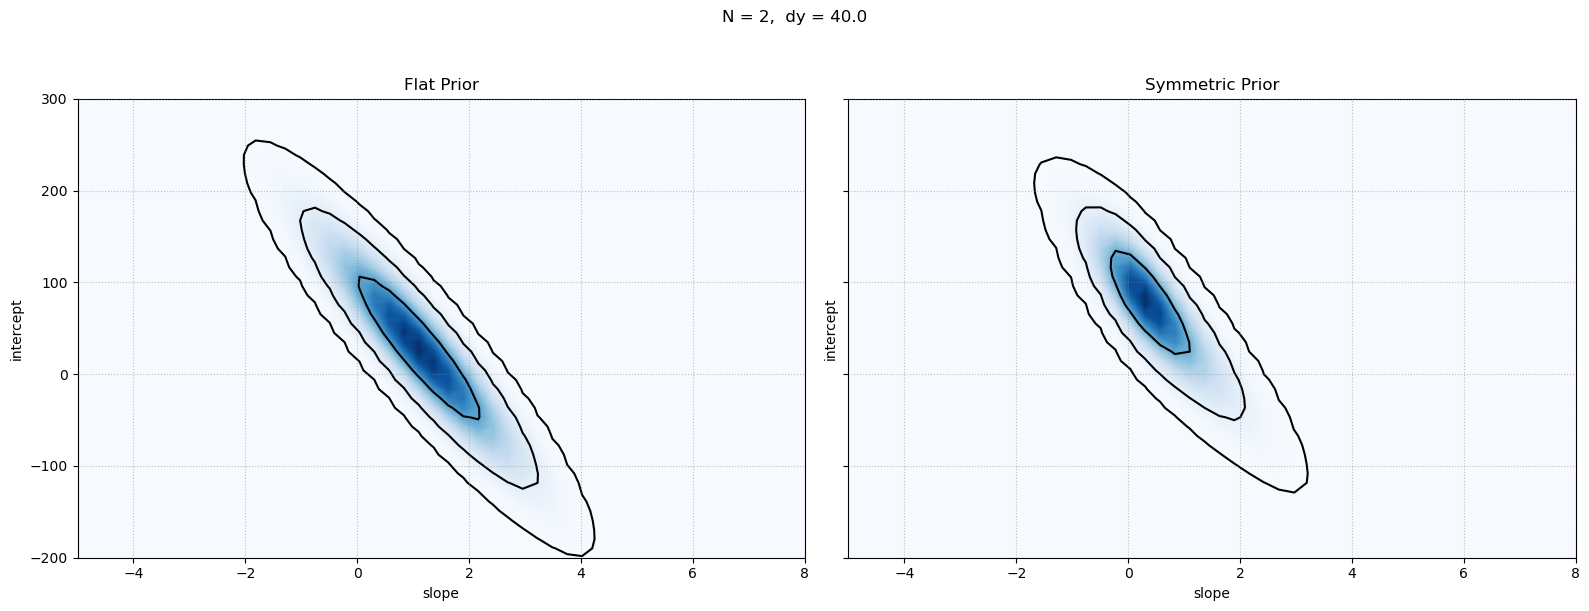

In [326]:
intercept = 25.   
slope = 0.5      
theta_true = [intercept, slope]

N=20
dy=40
x, y, dy = make_data(*theta_true, N,dy,rseed=42)
plot_results(x, y, dy,intercept_limits=(-60, 65),slope_limits=(-0.5,1.5))

N=10 
dy=40
x, y, dy = make_data(*theta_true, N,dy,rseed=42)
plot_results(x, y, dy,intercept_limits=(-100, 220),slope_limits=(-0.5,1.5))

N=5 
dy=40
x, y, dy = make_data(*theta_true, N,dy,rseed=42)
plot_results(x, y, dy,intercept_limits=(-100, 200),slope_limits=(-1,2))

N=2 
dy=40
x, y, dy = make_data(*theta_true, N,dy,rseed=42)
plot_results(x, y, dy,intercept_limits=(-200, 300),slope_limits=(-5, 8))

## B. Amplitude of a signal in the presence of background


1. Step through the notebook and make sure you understand the problem and its analysis. You may find the discussion in Section 3.1 of *Sivia and Skilling, Data Analysis: A Bayesian Tutorial* useful (see Carmen modules). You don't need to hand in anything for this part but please list here any questions you have.
<br><br><br><br>

1. Do the "Follow-ups": 
   * *Try both smaller and larger values of D and note the transition in the form of the pdf.*
   * At $D=12.5$ the pdf is already looking like a Gaussian (or what most of us imagine a Gaussian to look like).  *Prove that in the limit $D \rightarrow \infty$ that** 
   
$$
 p(N \mid D) \stackrel{D\rightarrow\infty}{\longrightarrow} \frac{1}{\sqrt{2\pi D}}e^{-(N-D)^2/(2D)}
$$

You'll want to use Stirling's formula:  $x! \rightarrow \sqrt{2\pi x}e^{-x} x^x$ as $x\rightarrow\infty$.
\[Hint: let $x = N = D(1+\delta)$ where $D\gg 1$ and $\delta \ll 1$.  And use $(1+\delta)^a = e^{a\ln (1+\delta)}$.\]

<br>

* *Show that this limit works in practice and visualize how close it is by adding the Gaussian pdf to the plot.* (See [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) or define a function yourself.)  **Add code below to make a figure here with the limiting Poisson histogram and the limiting Gaussian pdf.**
<br><br><br><br>

3. Based on your observations in running the different cases (and any additional ones you add), how should you optimally design an experiment to detect the amplitude of the signal given limited resources?  For example: How many counts are needed? How should you bin the data? What $(x_k)_{\rm max}$ should you use? 
<br><br><br><br>




### Solution to 2)

<br> Solution) We write the pmf for the poisson distribution,
<br>  $$ p(N \mid D) = \frac{D^N e^{-D}}{N!}, \implies \log (p(N \mid D) = N \log(D) -D -N\log(N)-\log(\sqrt{2 \pi N})+N = N \log(\frac{D}{N})+N-D-\log(\sqrt{2\pi N})$$. 
<br> Let y = N-D, the relevant taylor series expansion that we will do is y/D. This yields
<br> $$\log (p(N \mid D) = -(D+y)\log(1+\frac{y}{D})+y-\log(\sqrt{2\pi N})$$. Using $$log(1+x) = x-x^2/2+x^3/3...$$ for small x, we get
<br> $$\log (p(N \mid D) = -(D+y)(\frac{y}{D}-\frac{1}{2}(\frac{y}{D})^2+\frac{1}{3}(\frac{y}{D})^3+...)+y-\log(\sqrt{2\pi N}) \approx -\frac{1}{2}\frac{y^2}{D}-\log(\sqrt{2 \pi D(1+\delta)})$$. 
<br> Exponentiating both side, and using $$N \approx D, \delta \rightarrow 0^+$$, we get
<br> $$\log (p(N \mid D) = \frac{e^{-\frac{(N-D)^2}{2D}}}{\sqrt{2\pi D}}$$

In [137]:
import numpy as np
from math import factorial
import scipy.stats as stats  
import scipy.integrate as integrate
from scipy import interpolate

import matplotlib.pyplot as plt

# Define poissonian and gaussian distributions
def poisson(x,mu):
    assert (isinstance(x, int) and x >= 0), \
            "x must be a non-negative integer!"
    return (mu**x)*np.exp(-mu)/factorial(x)

def gaussian(x,mu,sigma):
    #Note mu is the mean, sigma is the variance
    return (np.exp(-1*(x-mu)**2/(2*sigma)))/(np.sqrt(2*np.pi*sigma))

0

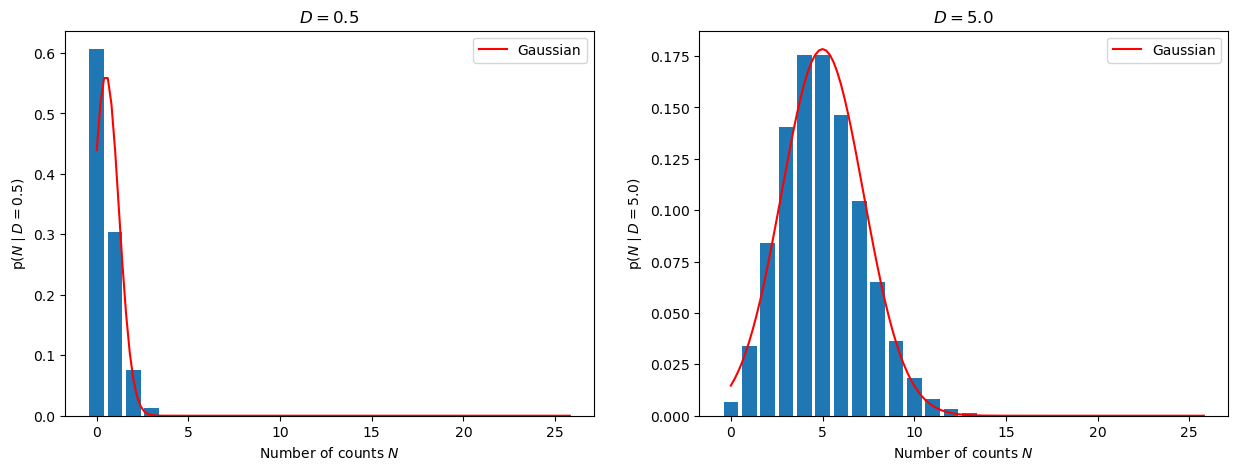

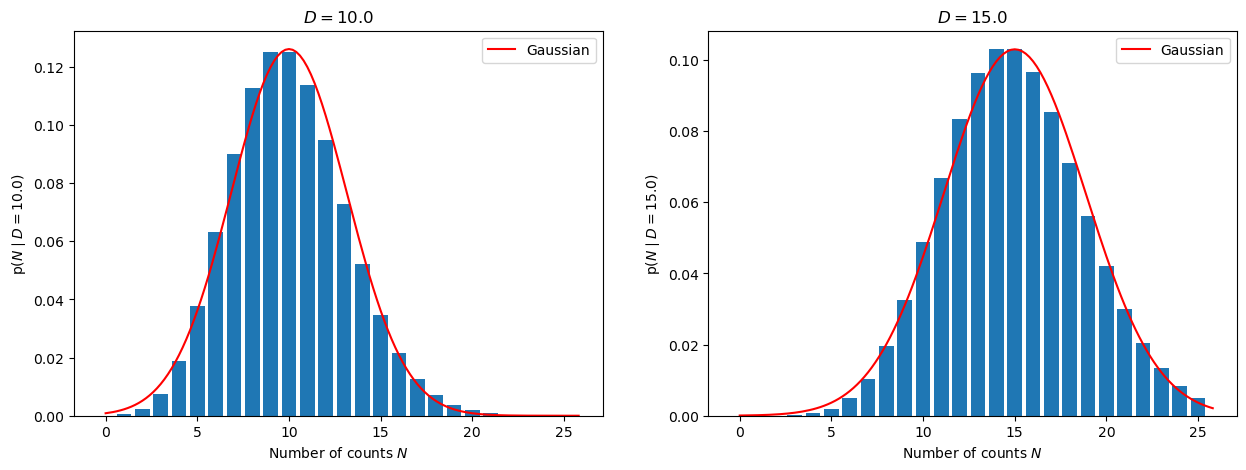

In [138]:
# Generate set of x_k for poissonian distribution

def Poisson_plot_generate(ax,mu,N_max):
    x_pts = np.arange(0,N_max+1,1,dtype=int)
    #print(x_pts)
    x_gs = np.arange(0,N_max+1,0.2)
    P_x = [poisson(int(x),mu) for x in x_pts]
    #print(P_x)
    G_x = [gaussian(x,mu,mu) for x in x_gs]

    ax.bar(x_pts, P_x/np.sum(P_x), width=0.8, bottom=None, align='center') #Scaling the y axis so that number of counts, P_x is less than 1
    ax.set_xlabel(r'Number of counts $N$')
    ax.set_ylabel(fr'$\mathrm{{p}}(N \mid D={mu:.1f})$')
    ax.set_title(rf'$D = {mu:.1f}$')
    ax.plot(x_gs,G_x,c='r',label="Gaussian")
    ax.legend(loc='best')
    return 0

mu_1 = 0.5
mu_2 = 5
mu_3 = 10
mu_4 = 15

N_max = 25

fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(1,2,1)
Poisson_plot_generate(ax1,mu_1,N_max)
ax2 = fig1.add_subplot(1,2,2)
Poisson_plot_generate(ax2,mu_2,N_max)

fig2 = plt.figure(figsize=(15,5))
ax3 = fig2.add_subplot(1,2,1)
Poisson_plot_generate(ax3,mu_3,N_max)
ax4 = fig2.add_subplot(1,2,2)
Poisson_plot_generate(ax4,mu_4,N_max)

### Solution to 3

<br> In order to estimate the amplitude of signal(A) the best, we can either increase the 1) No of databins, while keeping D_max fixed. 2) Increase D_max, but keep number of bins fixed. For our case, we will work with fixed delta_x, which means increasing number of databins increases x_max

<br> For situation 1, the best estimate of A is found when N_bins = 30, and D_max = 100(fixed)
<br> For situation 2, the best estimate of A is found when N_bins = 30(fixed), D_max = 500. Increasing D_max results in a sharper joint posterior distribution. 

<br> Since the peak of the marginalized distribution $$\int dB p(A,B|\{N_k\})$$ 
<br> gives the estimate of A,we can make a contour plot of the deviation of this estimate from the true value of A, which shows that given finite resources(hence moderate value of D_max), the best estimate can be found by increasing the number of databins, although the peak of the marginalized distribution is nonmonotonic in number of databins.

In [139]:
## Code below is taken from class notebook

A_true = 1.
B_true = 2.
width = np.sqrt(5.)   
x_0 = 0

def exact_data(A, B, n_0, x_k, x_0=0., width=np.sqrt(5.)):
    return n_0 * (A * np.exp(-(x_k - x_0)**2/(2.*width**2)) + B)

In [140]:
def make_dataset(A_true, B_true, width, x_0, databins, delta_x=1, D_max=100):
    
    # set up evenly spaced bins, centered on x_0
    x_max = x_0 + delta_x * (databins-1)/2
    xk_pts = np.arange(-x_max, x_max + delta_x, delta_x, dtype=int)
    
    # scale n_0 so maximum of the "true" signal plus background is D_max
    n_0 = D_max / (A_true + B_true)  
    Dk_pts = exact_data(A_true, B_true, n_0, xk_pts, width=width)
    
    # sample for each k to determine the measured N_k
    Nk_pts = [stats.poisson.rvs(mu=Dk) for Dk in Dk_pts]
    
    return xk_pts, Dk_pts, Nk_pts, x_max, n_0

In [141]:
# Define the pdfs and combine with Bayes' theorem.
def log_prior(A, B):
  
    A_max = 5.
    B_max = 5.
    # flat prior 
    if np.logical_and(A <= A_max, B <= B_max).all(): 
        return np.log(1/(A_max * B_max))
    else:
        return -np.inf

def log_likelihood(A, B, xk_pts, Nk_pts, n_0):
    Dk_pts = exact_data(A, B, n_0, xk_pts, width=width)
    try:
        return np.sum(Nk_pts * np.log(Dk_pts) - Dk_pts)
    except ValueError:
        return -np.inf
    
def log_posterior(A, B, xk_pts, Nk_pts, n_0):
    return log_prior(A, B) + log_likelihood(A, B, xk_pts, Nk_pts, n_0)

def normalize(y_pts, x_pts):
    return y_pts / integrate.simps(y_pts, x_pts)

def find_index(x_pts, x_value):

    return np.fabs(x_pts - x_value).argmin()

In [142]:
def find_contour_levels(grid):

    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997]) ** 2)
    return np.sort(sorted_[cutoffs])

def make_figs(databins, delta_x, D_max, flag=False):
 
    xk_pts, Dk_pts, Nk_pts, x_max, n_0 = make_dataset(A_true, B_true, width, 
                                                      x_0, databins, delta_x, 
                                                      D_max)
    total_counts = np.sum(Nk_pts)
    
    # Figure 1.
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(1,3,1)
    ax1.plot(xk_pts, Nk_pts, drawstyle='steps-mid', color='blue')
    ax1.set_xlim(-x_max, x_max)
    ax1.set_ylim(bottom = 0)
    ax1.set_xlabel(r'Measurement variable $x$')
    ax1.set_ylabel(r'Number of counts $N$')
    
    # Figure 2.  Can use contour or contourf.
    A_max = 3.; B_max = 3.
    A_pts = np.arange(0.01, A_max, .02)  # You may want to adjust the density
    B_pts = np.arange(0.01, B_max, .02)  #  of points used.
    A_grid, B_grid = np.meshgrid(A_pts, B_pts)    

    # Z_grid = Z(B, A) the way we define it here with a list comprehension.
    Z_grid = np.array([[log_posterior(A, B, xk_pts, Nk_pts, n_0) 
                        for A in A_pts] for B in B_pts])
    Z_grid = np.exp(Z_grid - np.max(Z_grid))  # normalize the peak to be 1
    ax2 = fig.add_subplot(1,3,2)
    ax2.axvline(A_true, color='gray', linestyle='--', alpha=0.8)
    ax2.axhline(B_true, color='gray', linestyle='--', alpha=0.8)

    ax2.contourf(A_grid, B_grid, Z_grid, levels=5, cmap='jet') 
    ax2.set_xlim(0., A_max)
    ax2.set_ylim(0., B_max)
    ax2.set_xlabel(r'Amplitude $A$')
    ax2.set_ylabel(r'Background $B$')
    
    # Figure 3.
    ax3 = fig.add_subplot(1,3,3) 
    B_true_index = find_index(B_pts, B_true)
    B_marginalized = [integrate.simps(Z_grid[:,i], B_pts) \
                                      for i in range(len(A_pts))]
    B_marginalized = normalize(B_marginalized, A_pts)
    B_true_fixed = Z_grid[B_true_index,:]
    B_true_fixed = normalize(B_true_fixed, A_pts)
    ax3.plot(A_pts, B_marginalized, color='blue', 
             label='marginalized over B')
    ax3.plot(A_pts, B_true_fixed, color='red', 
             linestyle='--', label='B = B_true')
    ax3.axvline(A_true, color='gray', linestyle='--', alpha=0.8)
    ax3.set_xlabel(r'Amplitude $A$')
    ax3.set_ylabel(r'${\rm p}(A | \{N_k\}, I)$')
    ax3.legend()
    
    
    # Figure 4.
    #ax4 = fig.add_subplot(2,2,4)
    #A_marginalized = [integrate.simps(Z_grid[j,:], A_pts) \
                                      #for j in range(len(B_pts))]
    #A_marginalized = normalize(A_marginalized, B_pts)
    #ax4.plot(B_pts, A_marginalized, color='blue',
             #label='marginalized over A')
    #ax4.set_xlabel(r'Background $B$')
    #ax4.set_ylabel(r'${\rm p}(B|\{N_k\}, I)$')
    #ax4.legend()
    
    overall_title = f'Total counts = {total_counts},  ' \
                    + f'# of bins = {databins}' \
                    + '\n'
    fig.suptitle(overall_title, y=1.01)
    
    fig.tight_layout()
    
    if (flag):
        fig2 = plt.figure(figsize=(12,6))
        # Figure 1.
        ax2_1 = fig2.add_subplot(2,2,1)
        contour_levels = [0.2, 0.4, 0.6, 0.8, 1.0]
        ax2_1.contour(A_grid, B_grid, Z_grid, levels=contour_levels)
        ax2_1.axvline(A_true, color='gray', linestyle='--', alpha=0.8)
        ax2_1.axhline(B_true, color='gray', linestyle='--', alpha=0.8)
        ax2_1.set_xlim(0., A_max)
        ax2_1.set_ylim(0., B_max)
        ax2_1.set_xlabel(r'Amplitude $A$')
        ax2_1.set_ylabel(r'Background $B$')
        ax2_1.set_title('Contour plot with levels 0.2, 0.4, 0.6, 0.8, 1.0')
        
        # Figure 2.
        ax2_2 = fig2.add_subplot(2,2,2)
        ax2_2.contourf(A_grid, B_grid, Z_grid, levels=5, cmap='jet') 
        ax2_2.axvline(A_true, color='gray', linestyle='--', alpha=0.8)
        ax2_2.axhline(B_true, color='gray', linestyle='--', alpha=0.8)
        ax2_2.set_xlim(0., A_max)
        ax2_2.set_ylim(0., B_max)
        ax2_2.set_xlabel(r'Amplitude $A$')
        ax2_2.set_ylabel(r'Background $B$')
        ax2_2.set_title('Color contour plot with contourf')
        
        # Figure 3.
        ax2_3 = fig2.add_subplot(2,2,3, projection='3d')
        ax2_3.plot_surface(A_grid, B_grid, Z_grid, rstride=1, cstride=1, 
                           cmap='jet', linewidth=0, antialiased=False,
                           edgecolor='none')
        ax2_3.set_xlim(0., A_max)
        ax2_3.set_ylim(0., B_max)
        ax2_3.set_xlabel(r'Amplitude $A$')
        ax2_3.set_ylabel(r'Background $B$')
        ax2_3.set_title('Surface plot')
        
        # Figure 4.
        ax2_4 = fig2.add_subplot(2,2,4)
        ax2_4.contour(A_grid, B_grid, Z_grid, 
                      levels=find_contour_levels(Z_grid))
        ax2_2.axvline(A_true, color='gray', linestyle='--', alpha=0.8)
        ax2_2.axhline(B_true, color='gray', linestyle='--', alpha=0.8)
        ax2_4.set_xlim(0., A_max)
        ax2_4.set_ylim(0., B_max)
        ax2_4.set_xlabel(r'Amplitude $A$')
        ax2_4.set_ylabel(r'Background $B$')
        ax2_4.set_title('Contours at 68%, 95%, 99.7%')
        fig2.tight_layout()
                
    return fig

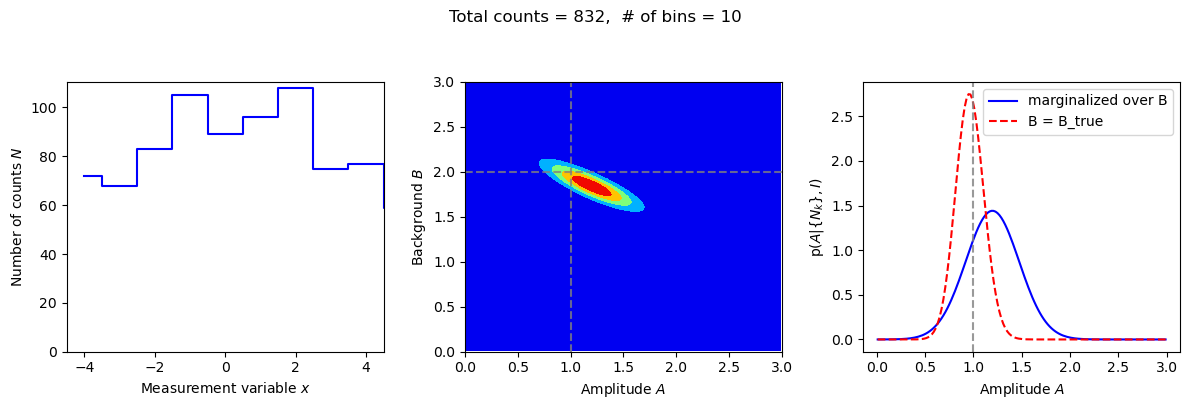

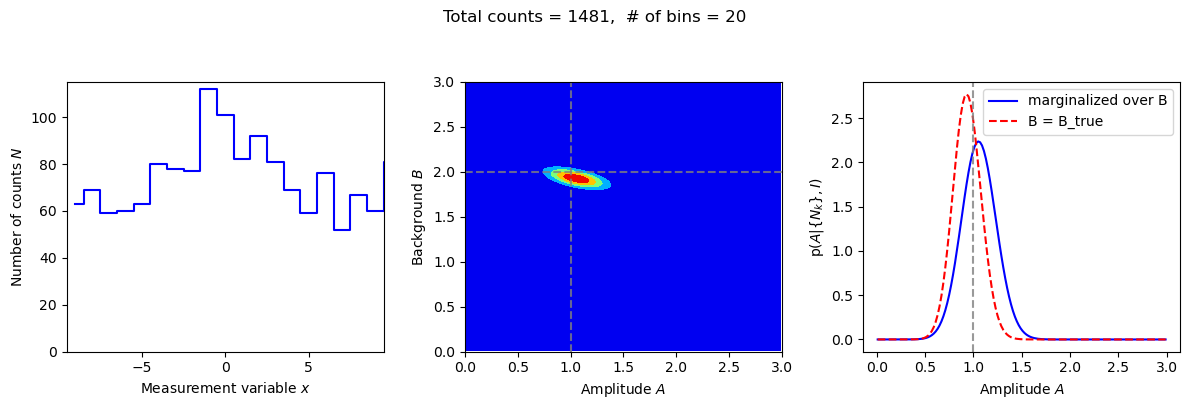

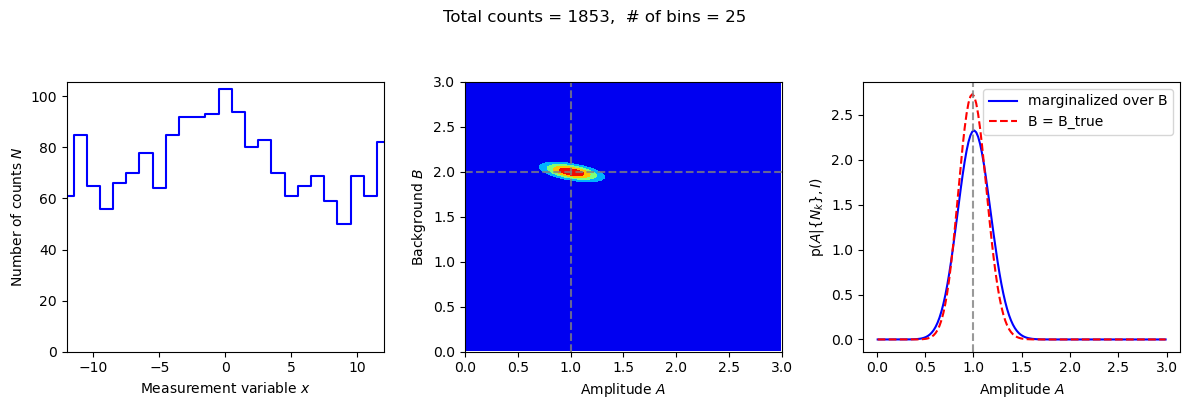

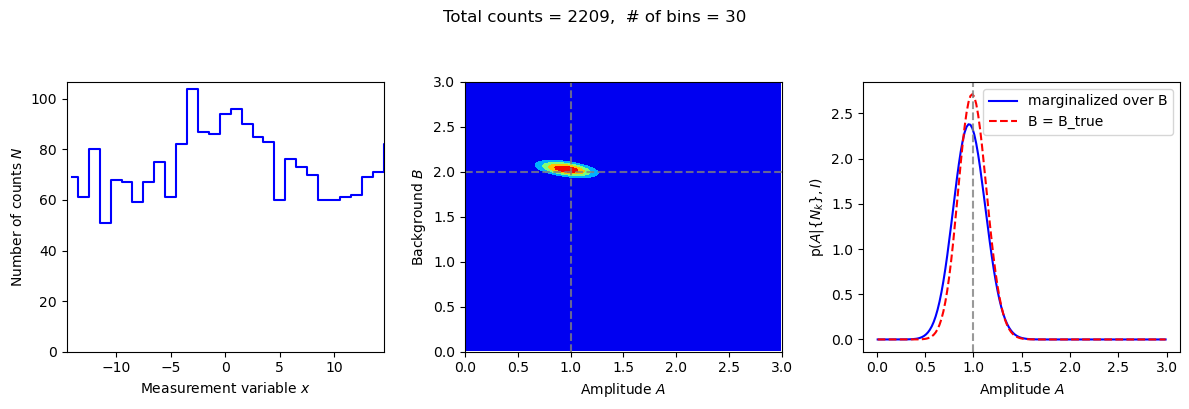

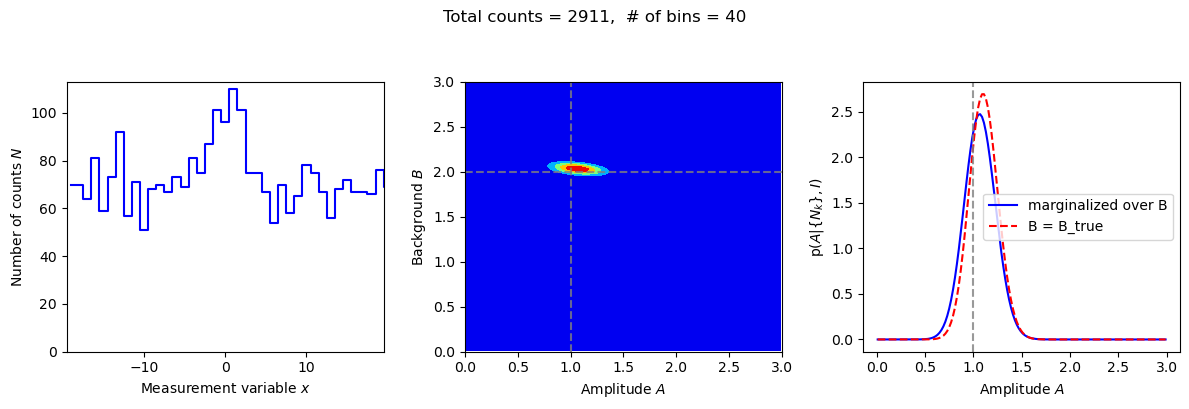

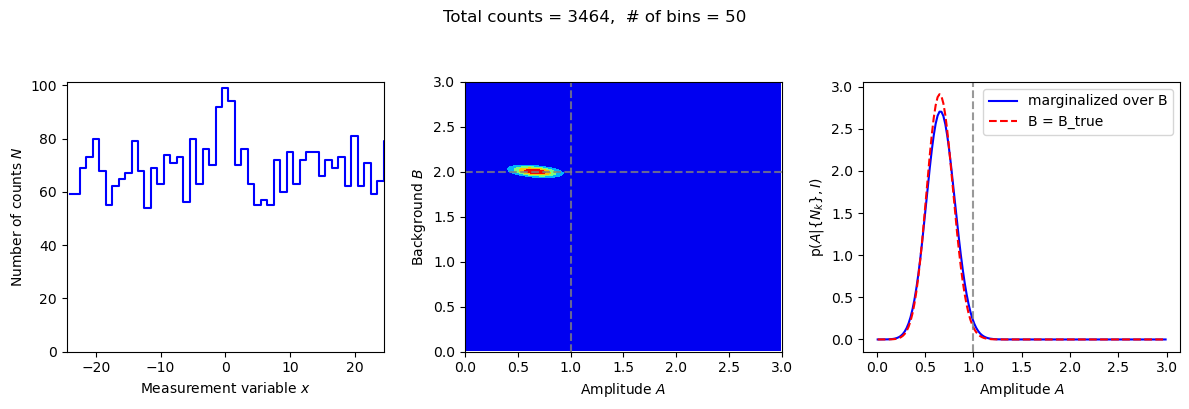

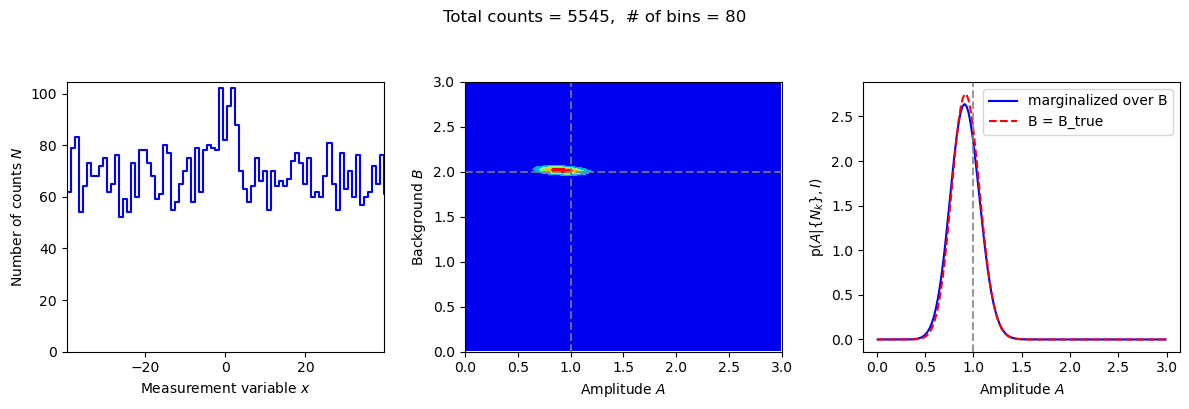

In [150]:
# case 1: maximum expection of 100 counts, but vary no of databins

D_max = 100
Databins = [10,20,25,30,40,50,80]
delta_x = 1

for databins in Databins:
    fig = make_figs(databins, delta_x, D_max, flag=False)

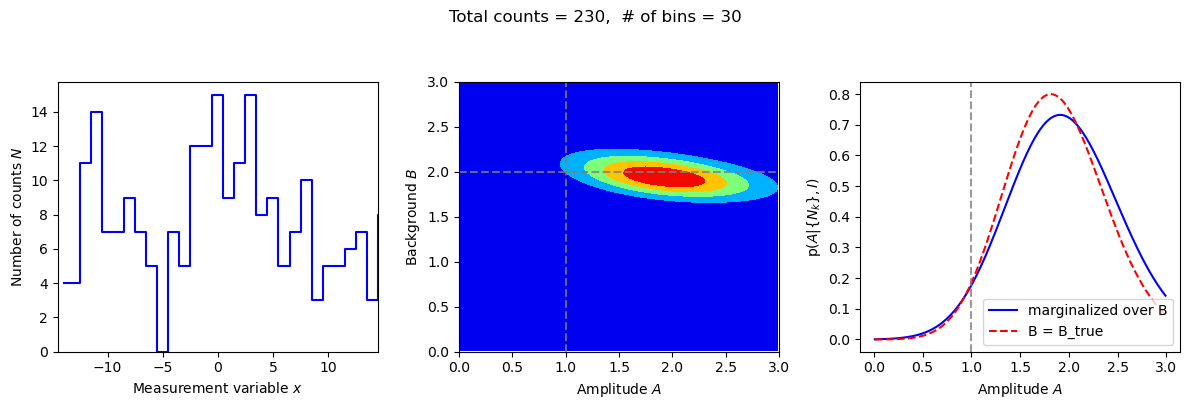

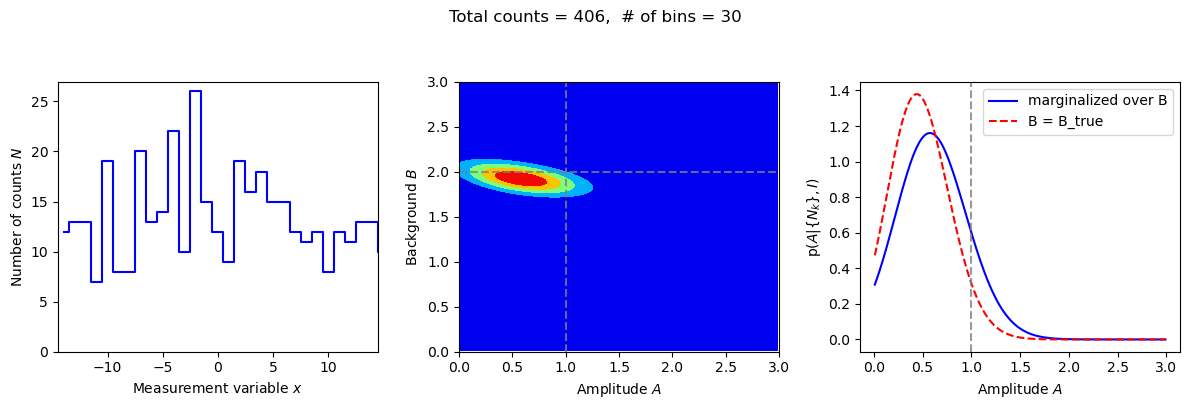

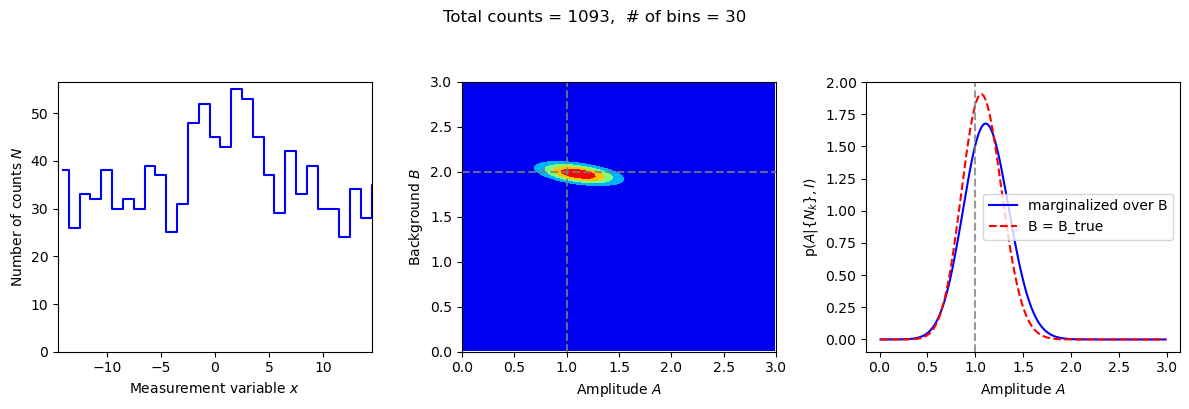

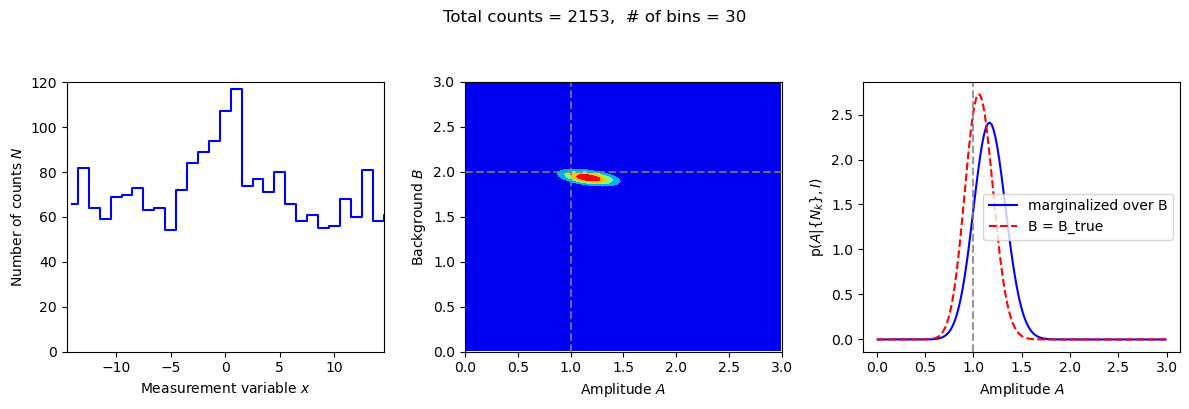

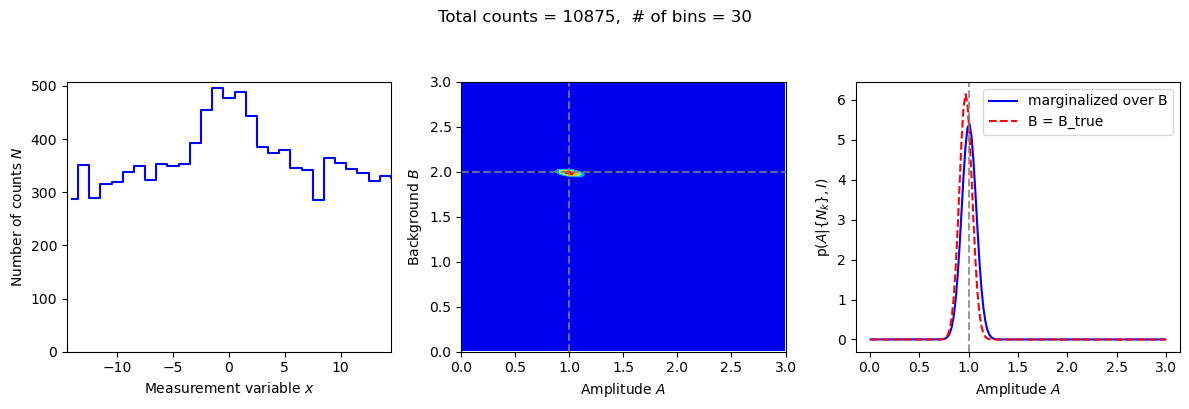

In [144]:
# case 2: Keep number of bins fixed at 30, vary maximum expection of counts
D_max = [10,20,50,100,500]
databins = 30
delta_x = 1

for d_max in D_max:
    fig = make_figs(databins, delta_x, d_max, flag=False)

In [145]:
def bin_count_estimate(databins, delta_x, D_max):  #This function calculates how much the estimated value of A is off from true value of A
 
    xk_pts, Dk_pts, Nk_pts, x_max, n_0 = make_dataset(A_true, B_true, width, 
                                                      x_0, databins, delta_x, 
                                                      D_max)
    total_counts = np.sum(Nk_pts)
    A_max = 3.; B_max = 3.
    A_pts = np.arange(0.01, A_max, .02)  # You may want to adjust the density
    B_pts = np.arange(0.01, B_max, .02)  #  of points used.
    A_grid, B_grid = np.meshgrid(A_pts, B_pts)    

    # Z_grid = Z(B, A) the way we define it here with a list comprehension.
    Z_grid = np.array([[log_posterior(A, B, xk_pts, Nk_pts, n_0) 
                        for A in A_pts] for B in B_pts])
    Z_grid = np.exp(Z_grid - np.max(Z_grid))  # normalize the peak to be 1

    B_marginalized = [integrate.simps(Z_grid[:,i], B_pts) for i in range(len(A_pts))]
    B_marginalized = normalize(B_marginalized, A_pts)
    A_opt_val = A_pts[np.argmax(B_marginalized)]
    #print(A_opt_val)
    return total_counts,np.abs(A_opt_val-A_true)

In [147]:
# We will create a 2D plot, showing how much does the deviation of the estimated value of A 
# from true value of A depend on number of bins used and D_max. since we are fixing delta_x = 1,
# x_max is determined solely by databins

Databins=np.arange(5,40,1,dtype=int)
D_max=np.arange(10,100,5)
delta_x=1

Bin_grid,Dmax_grid = np.meshgrid(Databins, D_max) 
Err_grid=np.array([[bin_count_estimate(databins, delta_x, d_max) for databins in Databins] for d_max in D_max])

Text(0, 0.5, '$D_{max}$')

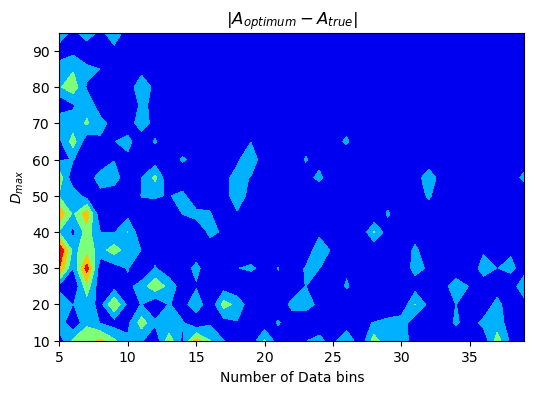

In [148]:
plt.figure(figsize=(6,4))    
plt.title(r"$|A_{optimum}-A_{true}|$")
plt.contourf(Bin_grid, Dmax_grid, Err, levels=5, cmap='jet') 
plt.xlabel(r'Number of Data bins')
plt.ylabel(r'$D_{max}$')